In [3]:
import numpy as np
import requests
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
SEED = 42
N_PER_CLASS = 200
FETCH_TARGET_PER_CLASS = 600   
TEST_SIZE = 0.15

OUT_DIR = "outputs"

METHOD_TERMS = '("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")'

CATEGORIES = [
    ("a", "Alzheimer", f'(Alzheimer* OR "Alzheimer disease" OR AD) AND {METHOD_TERMS}'),
    ("b", "Parkinson", f'(Parkinson* OR PD) AND {METHOD_TERMS}'),
    ("c", "Vascular dementia", f'("vascular dementia" OR "vascular cognitive impairment" OR VCI) AND {METHOD_TERMS}'),
    ("d", "MCI", f'("mild cognitive impairment" OR MCI) AND {METHOD_TERMS}'),
    ("e", "Lewy body dementia", f'("Lewy body dementia" OR DLB OR "dementia with lewy bodies") AND {METHOD_TERMS}'),
]

BASE_URL = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"

In [5]:
for label, cat, q in CATEGORIES:
    print(label, cat)
    print("  ", q)
    print()

a Alzheimer
   (Alzheimer* OR "Alzheimer disease" OR AD) AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")

b Parkinson
   (Parkinson* OR PD) AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")

c Vascular dementia
   ("vascular dementia" OR "vascular cognitive impairment" OR VCI) AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")

d MCI
   ("mild cognitive impairment" OR MCI) AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")

e Lewy body dementia
   ("Lewy body dementia" OR DLB OR "dementia with lewy bodies") AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")



In [6]:
def epmc_search_once(query, page_size=5):
    params = {
        "query": query,
        "format": "json",
        "resultType": "core",
        "pageSize": page_size
    }
    r = requests.get(BASE_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()


test_json = epmc_search_once(CATEGORIES[0][2], page_size=5)


results = test_json.get("resultList", {}).get("result", [])
len(results), results[0].get("title") if results else None

(5, 'Machine Learning in Primary Health Care: The Research Landscape.')

In [7]:
import time
import requests

def epmc_search_all(query, max_records=500, page_size=100, result_type="core", sleep=0.15):
    records = []
    cursor = "*"
    while len(records) < max_records:
        params = {
            "query": query,
            "format": "json",
            "resultType": result_type,
            "pageSize": page_size,
            "cursorMark": cursor
        }
        r = requests.get(BASE_URL, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()

        batch = data.get("resultList", {}).get("result", [])
        if not batch:
            break

        records.extend(batch)

        next_cursor = data.get("nextCursorMark")
        if not next_cursor or next_cursor == cursor:
            break
        cursor = next_cursor
        time.sleep(sleep)

    return records[:max_records]

In [8]:
FETCH_TARGET_PER_CLASS = 800  
all_rows = []

for label, cat, q in CATEGORIES:
    print(f"\nFetching {cat} ...")
    recs = epmc_search_all(q, max_records=FETCH_TARGET_PER_CLASS, page_size=100, result_type="core")
    print("Fetched:", len(recs))

    for x in recs:
        all_rows.append({
            "doc_id": f'{x.get("id","")}_{x.get("source","")}',
            "label": label,
            "category": cat,
            "title": x.get("title"),
            "abstract": x.get("abstractText"),
            "year": x.get("pubYear"),
            "doi": x.get("doi"),
            "journalTitle": x.get("journalTitle"),
            "pubType": x.get("pubType"),
            "source": x.get("source")
        })

raw_df = pd.DataFrame(all_rows)
print("\nRaw size:", raw_df.shape)
raw_df["label"].value_counts()


Fetching Alzheimer ...
Fetched: 800

Fetching Parkinson ...
Fetched: 800

Fetching Vascular dementia ...
Fetched: 800

Fetching MCI ...
Fetched: 800

Fetching Lewy body dementia ...
Fetched: 800

Raw size: (4000, 10)


label
a    800
b    800
c    800
d    800
e    800
Name: count, dtype: int64

In [9]:
df = raw_df.dropna(subset=["abstract"]).copy()


df["dedup_key"] = df["doi"].fillna("")
mask = df["dedup_key"].eq("")
df.loc[mask, "dedup_key"] = (
    df.loc[mask, "title"].fillna("").str.lower().str.strip()
    + "_"
    + df.loc[mask, "year"].fillna("").astype(str)
)

df = df.drop_duplicates(subset=["dedup_key"]).copy()

print("After filter+dedup:", df.shape)
df["label"].value_counts()

After filter+dedup: (2976, 11)


label
a    730
c    684
b    598
e    552
d    412
Name: count, dtype: int64

In [10]:
SEED = 42
N_PER_CLASS = 200

samples = []
for label, cat, _ in CATEGORIES:
    sub = df[df["label"] == label].copy()
    print(cat, "available:", len(sub))
    if len(sub) < N_PER_CLASS:
        raise ValueError(f"{cat} only has {len(sub)} records; increase FETCH_TARGET_PER_CLASS or relax query.")
    samples.append(sub.sample(n=N_PER_CLASS, random_state=SEED))

df200 = pd.concat(samples, ignore_index=True)
print("df200 shape:", df200.shape)
df200["label"].value_counts()

Alzheimer available: 730
Parkinson available: 598
Vascular dementia available: 684
MCI available: 412
Lewy body dementia available: 552
df200 shape: (1000, 11)


label
a    200
b    200
c    200
d    200
e    200
Name: count, dtype: int64

In [11]:
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def basic_clean(text: str) -> str:
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return ""
    text = str(text).replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^A-Za-z0-9\s\.\,\;\:\-\(\)\/%]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?", text)

def remove_stopwords(tokens):
    return [t for t in tokens if t.lower() not in ENGLISH_STOP_WORDS]

def make_record(title, abstract, n_words=100, remove_sw=True, use_title=True):
    title = basic_clean(title)
    abstract = basic_clean(abstract)
    text = f"{title} {abstract}".strip() if use_title else abstract
    tokens = tokenize(text)
    if remove_sw:
        tokens = remove_stopwords(tokens)
    tokens = tokens[:n_words]
    return " ".join(tokens)

def build_and_split(df_in, n_words, use_title, out_name, seed=42, test_size=0.15):
    out = df_in.copy()
    out["text"] = out.apply(lambda r: make_record(r["title"], r["abstract"], n_words=n_words, use_title=use_title), axis=1)
    out = out[out["text"].str.len() > 0].copy()

    train_df, test_df = train_test_split(
        out, test_size=test_size, random_state=seed, stratify=out["label"]
    )
    train_df["split"] = "train"
    test_df["split"] = "test"
    final = pd.concat([train_df, test_df], ignore_index=True)

    keep = ["doc_id","label","category","year","text","split","source","journalTitle","doi","pubType"]
    keep = [c for c in keep if c in final.columns]
    path = os.path.join(OUT_DIR, out_name)
    final[keep].to_csv(path, index=False, encoding="utf-8")
    print("Saved:", path, "| rows:", len(final))
    return final

In [12]:
data_title_abs_100 = build_and_split(df200, n_words=100, use_title=True,  out_name="data_title_abstract_100w.csv", seed=SEED, test_size=0.15)
data_abs_only_100  = build_and_split(df200, n_words=100, use_title=False, out_name="data_abstract_only_100w.csv", seed=SEED, test_size=0.15)


data_title_abs_20  = build_and_split(df200, n_words=20,  use_title=True,  out_name="data_title_abstract_20w.csv", seed=SEED, test_size=0.15)

Saved: outputs\data_title_abstract_100w.csv | rows: 1000
Saved: outputs\data_abstract_only_100w.csv | rows: 1000
Saved: outputs\data_title_abstract_20w.csv | rows: 1000


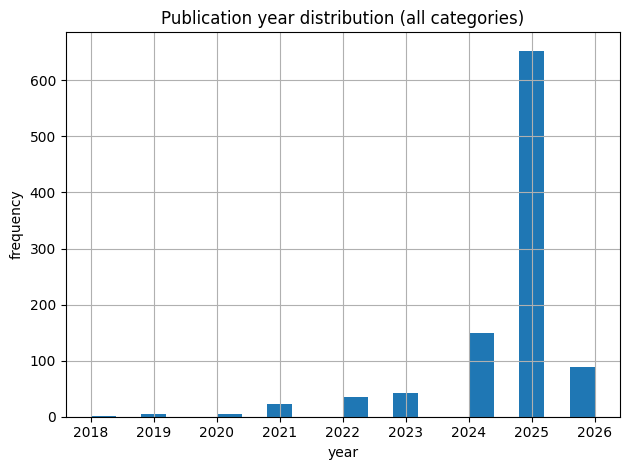

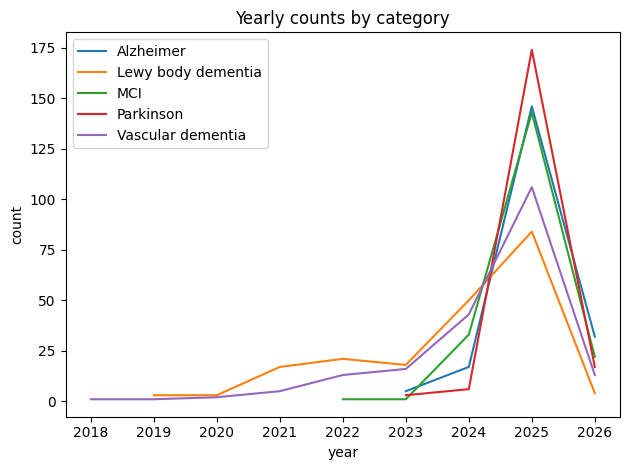

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os

p_main = "outputs/data_title_abstract_100w.csv"
df_main = pd.read_csv(p_main)

df_main["year_num"] = pd.to_numeric(df_main["year"], errors="coerce")
years = df_main["year_num"].dropna()

years.hist(bins=20)
plt.title("Publication year distribution (all categories)")
plt.xlabel("year")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()


trend = (
    df_main.dropna(subset=["year_num"])
          .groupby(["category", "year_num"])
          .size()
          .reset_index(name="count")
)

for cat in trend["category"].unique():
    sub = trend[trend["category"] == cat].sort_values("year_num")
    plt.plot(sub["year_num"], sub["count"], label=cat)

plt.title("Yearly counts by category")
plt.xlabel("year")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

## Part 2

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [17]:
df = pd.read_csv("outputs/data_title_abstract_100w.csv")


train_df = df[df['split'] == 'train'].copy()
X_train_text = train_df['text'].fillna("") # Handle potential null values
y_train = train_df['category']             # labels (a, b, c, d, e)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

# Feature Engineering: TF-IDF & N-gram
tfidf = TfidfVectorizer(
    stop_words='english',      # Remove English stop words such as "the, is, at..."
    ngram_range=(1, 2),        # Unigrams + Bigrams
    max_features=5000,         # Limit to top 5000 features
    sublinear_tf=True          
)

print("\nTF-IDF transformation in progress...")
X_train_vec = tfidf.fit_transform(X_train_text)

print(f"transformation complete! Shape of the generated feature matrix is {X_train_vec.shape}") #


TF-IDF transformation in progress...
transformation complete! Shape of the generated feature matrix is (850, 5000)


In [18]:
# Model training & 10-Fold Cross-Validation
# We select Naive Bayes, SVM, random forest, etc. to train the model
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear)": LinearSVC(random_state=42, dual='auto'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": xgb.XGBClassifier(
        random_state=42, 
        eval_metric='mlogloss',
        use_label_encoder=False,
        tree_method='hist'
    )
}

print("\nStart executing 10-Fold Cross-Validation...")
print("-" * 75)
print(f"{'Model Name':<20} | {'Mean Accuracy':<15} | {'Std Dev (Variability)':<15}")
print("-" * 75)

results = {}

# Setting up StratifiedKFold to maintain class distribution in each fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train_vec, y_train_enc, cv=cv, scoring='accuracy')
    
    results[name] = scores
    mean_score = scores.mean()
    std_dev = scores.std()
    
    # Mean represents accuracy and standard deviation represents variability
    print(f"{name:<20} | {mean_score:.4f}          | {std_dev:.4f}")

print("-" * 60)

# Usually we select the model with the highest mean accuracy with the least std dev as the champion model.
best_model_name = max(results, key=lambda k: results[k].mean())
print(f"\nAccording to the results, the Champion Model is: {best_model_name}")


Start executing 10-Fold Cross-Validation...
---------------------------------------------------------------------------
Model Name           | Mean Accuracy   | Std Dev (Variability)
---------------------------------------------------------------------------
Naive Bayes          | 0.6047          | 0.0438
SVM (Linear)         | 0.6212          | 0.0282
Random Forest        | 0.6047          | 0.0289
KNN                  | 0.5318          | 0.0493


c:\Users\litia\anaconda3\envs\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:37:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\litia\anaconda3\envs\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:37:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\litia\anaconda3\envs\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:37:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\litia\anaconda3\envs\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:37:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_en

XGBoost              | 0.5835          | 0.0354
------------------------------------------------------------

According to the results, the Champion Model is: SVM (Linear)


## part 3

Retraining the champion model: SVM (Linear) ...

The final accuracy (Test Set) is: 0.5933

Classification report (Classification Report):
                    precision    recall  f1-score   support

         Alzheimer       0.27      0.20      0.23        30
Lewy body dementia       0.76      0.83      0.79        30
               MCI       0.68      0.70      0.69        30
         Parkinson       0.51      0.60      0.55        30
 Vascular dementia       0.66      0.63      0.64        30

          accuracy                           0.59       150
         macro avg       0.58      0.59      0.58       150
      weighted avg       0.58      0.59      0.58       150



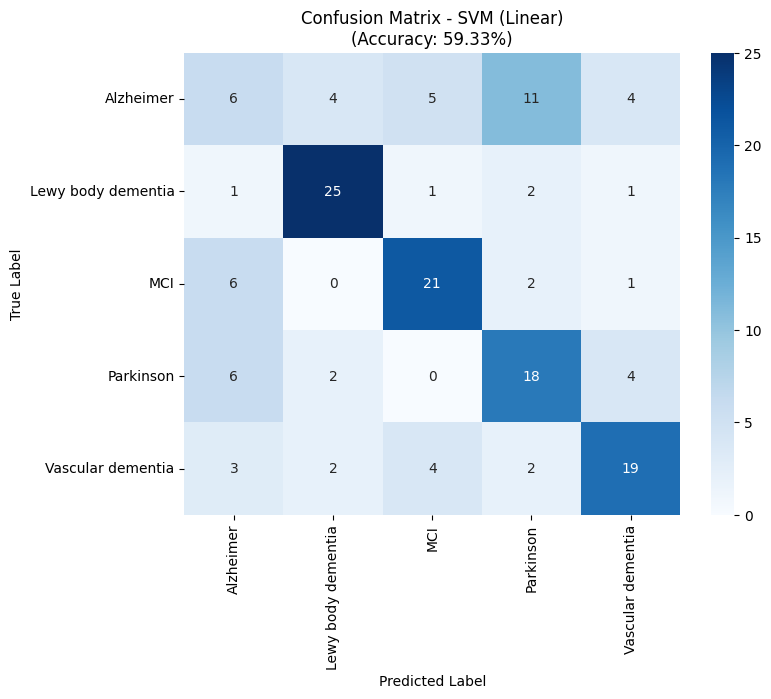


Misclassified Examples:
- [Real: Alzheimer | Prediction: Lewy body dementia] Text segment: relationship amyloid peptide spectrum spastic paraparesis phenotype autosomal do...
- [Real: MCI | Prediction: Parkinson] Text segment: Deep learning based triple tracer brain PET scanning single session simulation s...
- [Real: Alzheimer | Prediction: Lewy body dementia] Text segment: Frontotemporal dementia systematic review artificial intelligence approaches dif...


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Prepare the test set, and we need to transform it using the same TF-IDF as training set
test_df = df[df['split'] == 'test'].copy()
X_test_text = test_df['text'].fillna("")

# Use LabelEncoder to encode test labels for compatibility with XGBoost
y_test_enc = le.transform(test_df['category'])

X_test_vec = tfidf.transform(X_test_text)

# Use the full training set to retrain the champion model
champion_model = models[best_model_name]
print(f"Retraining the champion model: {best_model_name} ...")
champion_model.fit(X_train_vec, y_train_enc)

# Predict on the test set
y_pred = champion_model.predict(X_test_vec)
final_acc = accuracy_score(y_test_enc, y_pred)

print(f"\nThe final accuracy (Test Set) is: {final_acc:.4f}")
print("\nClassification report (Classification Report):")
# target_names corresponds to the 5 categories [a, b, c, d, e]
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}\n(Accuracy: {final_acc:.2%})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Error Analysis: Show some misclassified examples
print("\nMisclassified Examples:")
test_df['predicted'] = le.inverse_transform(y_pred)
misclassified = test_df[test_df['category'] != test_df['predicted']]

if not misclassified.empty:
    for i, row in misclassified.head(3).iterrows():
        print(f"- [Real: {row['category']} | Prediction: {row['predicted']}] Text segment: {row['text'][:80]}...")
else:
    print("The model made no mistakes")

## Part 4: increase the level of difficulty


The 'Harder Prediction' Experiment
Original dataset (100 words) accuracy: 0.5933
Harder dataset (20 words) accuracy: 0.5467
Accuracy dropped by: 4.67%


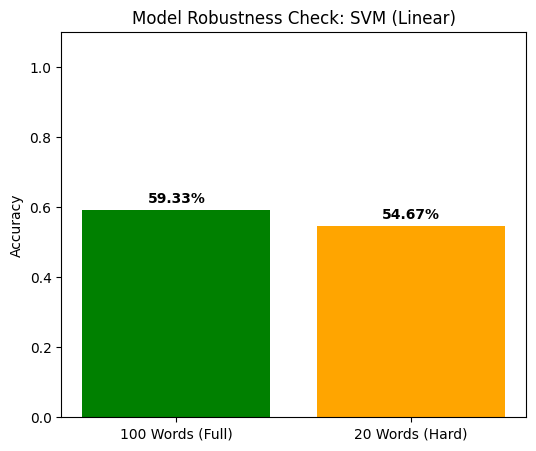


Bias & Variability Overlay

Temporal Bias:
Year_Group
Post-2020    0.546667
Name: Is_Correct, dtype: float64


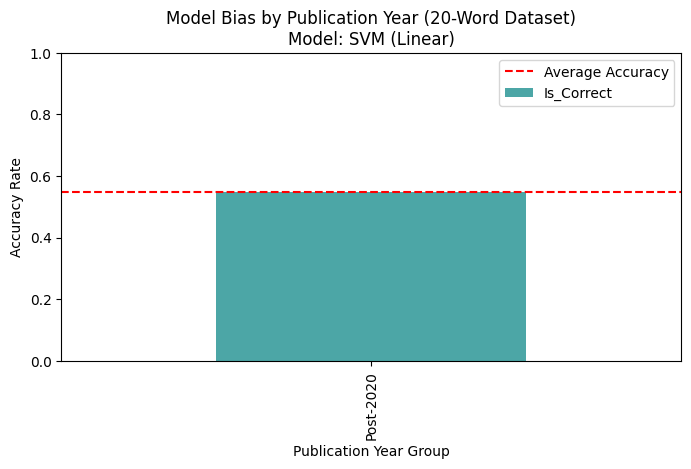


Category/Genre Bias:
category
Alzheimer             0.466667
Parkinson             0.533333
MCI                   0.566667
Vascular dementia     0.566667
Lewy body dementia    0.600000
Name: Is_Correct, dtype: float64


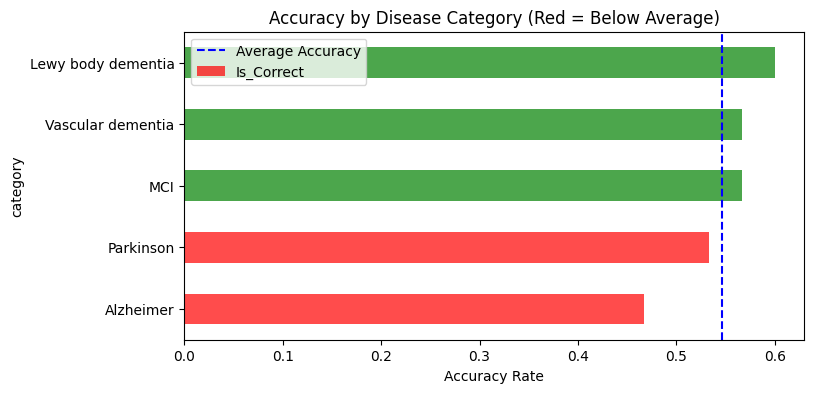


Auto Generated Insights:
1. Time Dimension: The model performed worst on papers from 'Post-2020'.
   Possible Reason: Earlier papers may use different terminology than modern ones, or simply due to the limited 20-word context missing key information.
2. Category Dimension: The model struggled most with the category 'Alzheimer'.
   (Possible Reason: This category's abstracts may contain more generic terms, making it harder to distinguish from other dementia subtypes.)


In [22]:
print("\n" + "="*80)
print("The 'Harder Prediction' Experiment")
print("="*80)

# 1. Load the 20-word version of the "harder" dataset
df_20w = pd.read_csv("outputs/data_title_abstract_20w.csv")

# 2. Prepare the data (Train/Test)
train_20w = df_20w[df_20w['split'] == 'train']
test_20w = df_20w[df_20w['split'] == 'test']

# 3. FE
tfidf_20w = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
X_train_20w_vec = tfidf_20w.fit_transform(train_20w['text'].fillna(""))
X_test_20w_vec = tfidf_20w.transform(test_20w['text'].fillna(""))

# Encode labels
y_train_20w = le.transform(train_20w['category'])
y_test_20w = le.transform(test_20w['category'])

# 4. Train & Evaluate the champion model on the 20-word dataset
from sklearn.base import clone
model_20w = clone(models[best_model_name]) 

model_20w.fit(X_train_20w_vec, y_train_20w)
y_pred_20w = model_20w.predict(X_test_20w_vec)
acc_20w = accuracy_score(y_test_20w, y_pred_20w)

# 5. Results
drop = final_acc - acc_20w
print(f"Original dataset (100 words) accuracy: {final_acc:.4f}")
print(f"Harder dataset (20 words) accuracy: {acc_20w:.4f}")
print(f"Accuracy dropped by: {drop:.2%}")

# 6. Bar Chart
plt.figure(figsize=(6, 5))
plt.bar(['100 Words (Full)', '20 Words (Hard)'], [final_acc, acc_20w], color=['green', 'orange'])
plt.title(f'Model Robustness Check: {best_model_name}')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
for i, v in enumerate([final_acc, acc_20w]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')
plt.show()


# Bias & Variability Analysis

print("\n" + "="*80)
print("Bias & Variability Overlay")
print("="*80)

# We need to combine the predictions with the original metadata
analysis_df = test_20w.copy() # Copy the testing set data
analysis_df['True_Label'] = le.transform(analysis_df['category']) 
analysis_df['Pred_Label'] = y_pred_20w # Predicted labels

analysis_df['Is_Correct'] = analysis_df['True_Label'] == analysis_df['Pred_Label']

# Factor A: Date of Publication

analysis_df['year_num'] = pd.to_numeric(analysis_df['year'], errors='coerce')
analysis_df = analysis_df.dropna(subset=['year_num']) # Remove rows without year

# Determine the time range：Pre-2010, 2010-2015, 2016-2020, Post-2020
bins = [1900, 2010, 2015, 2020, 2030]
labels = ['Pre-2010', '2011-2015', '2016-2020', 'Post-2020']
analysis_df['Year_Group'] = pd.cut(analysis_df['year_num'], bins=bins, labels=labels)

# Calculate accuracy per year group
year_bias = analysis_df.groupby('Year_Group')['Is_Correct'].mean()

print("\nTemporal Bias:")
print(year_bias)

# Plot: Yearly Bias
plt.figure(figsize=(8, 4))
year_bias.plot(kind='bar', color='teal', alpha=0.7)
plt.title(f'Model Bias by Publication Year (20-Word Dataset)\nModel: {best_model_name}')
plt.ylabel('Accuracy Rate')
plt.xlabel('Publication Year Group')
plt.ylim(0, 1.0)
plt.axhline(y=analysis_df['Is_Correct'].mean(), color='r', linestyle='--', label='Average Accuracy')
plt.legend()
plt.show()

# 3. Factor B: Genre/Category
class_bias = analysis_df.groupby('category')['Is_Correct'].mean().sort_values()

print("\nCategory/Genre Bias:")
print(class_bias)

# Plot: Category Bias
plt.figure(figsize=(8, 4))
colors = ['red' if x < analysis_df['Is_Correct'].mean() else 'green' for x in class_bias]
class_bias.plot(kind='barh', color=colors, alpha=0.7)
plt.title('Accuracy by Disease Category (Red = Below Average)')
plt.xlabel('Accuracy Rate')
plt.axvline(x=analysis_df['Is_Correct'].mean(), color='blue', linestyle='--', label='Average Accuracy')
plt.legend()
plt.show()

# Identify the worst performing year group and category
worst_year = year_bias.idxmin()
worst_class = class_bias.idxmin()

print("\nAuto Generated Insights:")
print(f"1. Time Dimension: The model performed worst on papers from '{worst_year}'.")
print(f"   Possible Reason: Earlier papers may use different terminology than modern ones, or simply due to the limited 20-word context missing key information.")
print(f"2. Category Dimension: The model struggled most with the category '{worst_class}'.")
print(f"   (Possible Reason: This category's abstracts may contain more generic terms, making it harder to distinguish from other dementia subtypes.)")

In [23]:
# Measure the AUC for multiclass classification

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_multiclass_auc(model, X_data, y_data, classes):
    """
    Calculates weighted AUC for multiclass classification.
    Handles models with predict_proba (like NB/RF) and decision_function (like SVM).
    """
    # Binarize labels for One-vs-Rest AUC calculation
    y_bin = label_binarize(y_data, classes=range(len(classes)))
    
    # Get probabilities or decision function scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_data)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_data)
    else:
        raise AttributeError("Model does not support probability or decision function.")

    # Calculate AUC
    auc = roc_auc_score(y_bin, y_score, multi_class='ovr', average='weighted')
    return auc


# Calculate AUC for the original (100-word) dataset
auc_100w = calculate_multiclass_auc(champion_model, X_test_vec, y_test_enc, le.classes_)

# Calculate AUC for the harder (20-word) dataset
auc_20w = calculate_multiclass_auc(model_20w, X_test_20w_vec, y_test_20w, le.classes_)

print("="*60)
print("MEASURING PREDICTION HARDSHIP (AUC SCORE)")
print("="*60)
print(f"Original Dataset (100 words) AUC: {auc_100w:.4f}")
print(f"Harder Dataset   (20 words)  AUC: {auc_20w:.4f}")
print(f"Drop in Distinguishability (AUC): {auc_100w - auc_20w:.4f}")

MEASURING PREDICTION HARDSHIP (AUC SCORE)
Original Dataset (100 words) AUC: 0.8683
Harder Dataset   (20 words)  AUC: 0.8151
Drop in Distinguishability (AUC): 0.0532


In [ ]:
# Identify Factors of Prediction using SHAP
import shap
import matplotlib.pyplot as plt


print("\n" + "="*60)
print("IDENTIFYING FACTORS OF PREDICTION (SHAP ANALYSIS)")
print("="*60)


if best_model_name in ["SVM (Linear)", "Logistic Regression"]:
    X_train_summary = shap.kmeans(X_train_vec, 10)
    explainer = shap.KernelExplainer(champion_model.predict, X_train_summary)
    
    print("Calculating SHAP values (this may take a minute)...")
    shap_values = explainer.shap_values(X_test_vec[:20])

    if isinstance(shap_values, list):
        shap_matrix = shap_values[0]
        print("Multiple output detected, plotting feature importance for class 0...")
    else:
        shap_matrix = shap_values
        print("Single output detected, plotting feature importance...")

    shap.summary_plot(shap_matrix, X_test_vec[:20], feature_names=tfidf.get_feature_names_out())

else:
    print("SHAP example above is optimized for Linear SVM. For Tree models (RF/XGB), use shap.TreeExplainer.")

  Using cached shap-0.50.0-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.63.1-cp312-cp312-win_amd64.whl.metadata (3.0 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached llvmlite-0.46.0-cp312-cp312-win_amd64.whl.metadata (5.1 kB)
  Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached shap-0.50.0-cp312-cp312-win_amd64.whl (549 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.63.1-cp312-cp312-win_amd64.whl (2.8 MB)
Using cached llvmlite-0.46.0-cp312-cp312-win_amd64.whl (38.1 MB)
Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl (12.8 MB)
Using cached tqdm-4.67.3-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.1.2-py3-none-any.whl (22 kB)
Using cached typing_extensions-4.15.0-py3-

  You can safely remove it manually.
  You can safely remove it manually.


ImportError: Numba needs NumPy 2.3 or less. Got NumPy 2.4.